In [ ]:
import pm4py
log_all = pm4py.read_xes('BPI_Challenge_2012.xes')

In [2]:
print(f'activities: {sorted(list(pm4py.get_event_attribute_values(log_all,"concept:name").keys()))}')

activities: ['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads', 'W_Beoordelen fraude', 'W_Completeren aanvraag', 'W_Nabellen incomplete dossiers', 'W_Nabellen offertes', 'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']


In [3]:
# We only look at subtraces of activities starting with an 'A'.
log = pm4py.filter_event_attribute_values(
    log_all,
    "concept:name",
    ['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED'],
    level="event",
    retain=True)


In [4]:
pm4py.write_xes(log, "BPI Challenge 2012 only A.xes")

exporting log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

### Analysis

In [1]:
import pm4py
log = pm4py.read_xes('BPI Challenge 2012 only A.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

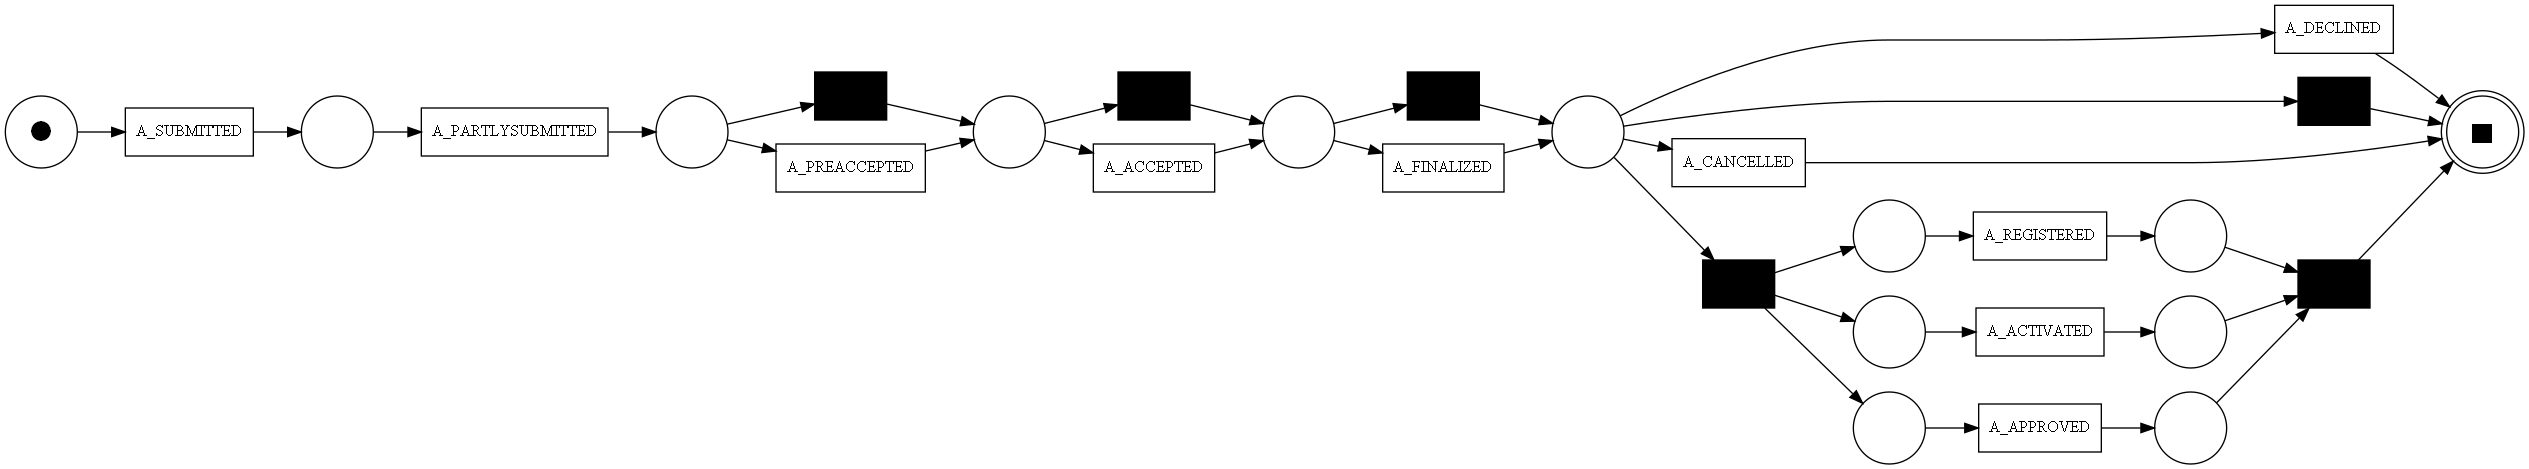

In [2]:
from exdpn.petri_net import get_petri_net

net, im, fm = get_petri_net(log, miner_type='IM')
pm4py.view_petri_net(net, im, fm)

As we can see, we have three decision points in our log / the corresponding Petri net.
We now take all trace-level and event-level attributes that do not have ID-esque semantics:

In [3]:
event_attrs = list(pm4py.get_event_attributes(log))
trace_attrs = list(pm4py.get_trace_attributes(log))

In [4]:
trace_attrs.remove("REG_DATE")

In [6]:
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("concept:name")

ValueError: list.remove(x): x not in list

We try to find suitable hyperparameters.

In [7]:
from sklearn.model_selection import GridSearchCV
import numpy as np 
from exdpn.petri_net import get_petri_net
from exdpn.guard_datasets import extract_all_datasets
from exdpn.data_preprocessing import basic_data_preprocessing
from exdpn.data_preprocessing.data_preprocessing import apply_ohe, apply_scaling, fit_scaling, fit_ohe

# prepare data
dp_dataset_map = extract_all_datasets(log= log, net=net, initial_marking=im, final_marking=fm, 
                                      event_level_attributes = event_attrs,
                                      case_level_attributes=trace_attrs)

# decision points 
dps = list(dp_dataset_map.keys())
total_size = sum(len(dp_dataset_map[key]) for key in dps)

We have observed that decision trees tend to be enormously large without any hyperparameters. We thus try to find an optimal `min_impurity_decrease` value.

In [9]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'min_impurity_decrease': (0, 0.01, 0.05, 0.1, 0.15)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset, numeric_attributes=["AMOUNT_REQ"])
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    dt_base = DecisionTreeClassifier()
    dt_grid = GridSearchCV(dt_base, parameters, n_jobs=-1, scoring='f1_weighted')

    dt_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(dt_grid.best_score_,4)}\t {dt_grid.best_params_}")
    best_values[dp] = dt_grid.best_params_

dt_param = {param: sum(val[param]*len(dp_dataset_map[key]) for key,val in best_values.items())/total_size for param in parameters.keys()}
print(f"final value: {dt_param}")

p_4:	0.6175	 {'min_impurity_decrease': 0.01}
p_5:	0.8291	 {'min_impurity_decrease': 0.01}
p_6:	0.9925	 {'min_impurity_decrease': 0.01}
p_7:	0.6915	 {'min_impurity_decrease': 0}
final value: {'min_impurity_decrease': 0.007500000000000001}


SVMs:

In [10]:
from sklearn.svm import LinearSVC
parameters = {'C':(0.1, 0.25, 0.5), 'tol': (0.001, 0.0005, 0.0015)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset, numeric_attributes=["AMOUNT_REQ"])
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    svm_base = LinearSVC()
    svm_grid = GridSearchCV(svm_base, parameters, n_jobs=-1, scoring='f1_weighted')

    svm_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(svm_grid.best_score_,4)}\t {svm_grid.best_params_}")

    best_values[dp] = svm_grid.best_params_

svm_param = {param: sum(val[param]*len(dp_dataset_map[key]) for key,val in best_values.items())/total_size for param in parameters.keys()}
print(f"final value: {svm_param}")

p_4:	0.6177	 {'C': 0.1, 'tol': 0.001}
p_5:	0.8266	 {'C': 0.5, 'tol': 0.001}
p_6:	0.9925	 {'C': 0.1, 'tol': 0.001}
p_7:	0.7126	 {'C': 0.5, 'tol': 0.001}
final value: {'C': 0.3, 'tol': 0.001}


NNs:

In [11]:
from sklearn.neural_network import MLPClassifier
parameters = {'hidden_layer_sizes': ((5, ), (5, 5), (10, 10)), 'learning_rate': ('constant', 'invscaling', 'adaptive')}

best_values = {}
max_ds_size = -1
max_ds_key = None

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    if len(dp_dataset) > max_ds_size: max_ds_key = dp
    X_train, y_train = basic_data_preprocessing(dp_dataset, numeric_attributes=["AMOUNT_REQ"])
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    nn_base = MLPClassifier()
    nn_grid = GridSearchCV(nn_base, parameters, n_jobs=-1, scoring='f1_weighted', cv=2)

    nn_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(nn_grid.best_score_,4)}\t {nn_grid.best_params_}")
    best_values[dp] = nn_grid.best_params_

nn_param = {param: best_values[max_ds_key][param] for param in parameters.keys()}
print(f"final value: {nn_param}")

p_4:	0.6194	 {'hidden_layer_sizes': (5,), 'learning_rate': 'invscaling'}
p_5:	0.8315	 {'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive'}
p_6:	0.9925	 {'hidden_layer_sizes': (5,), 'learning_rate': 'constant'}
p_7:	0.7122	 {'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive'}
final value: {'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive'}


LR:

In [12]:
from sklearn.linear_model import LogisticRegression
parameters = {'C': (0.1, 0.25, 0.5), 'tol': (0.001, 0.0005, 0.0015)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset, numeric_attributes=["AMOUNT_REQ"])
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    lr_base = LogisticRegression()
    lr_grid = GridSearchCV(lr_base, parameters, n_jobs=-1, scoring='f1_weighted', cv=2)

    lr_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(lr_grid.best_score_,4)}\t {lr_grid.best_params_}")
    best_values[dp] = lr_grid.best_params_

lr_param = {param: sum(val[param]*len(dp_dataset_map[key]) for key,val in best_values.items())/total_size for param in parameters.keys()}
print(f"final value: {lr_param}")

p_4:	0.6187	 {'C': 0.1, 'tol': 0.001}
p_5:	0.8287	 {'C': 0.1, 'tol': 0.001}
p_6:	0.9925	 {'C': 0.1, 'tol': 0.001}
p_7:	0.7124	 {'C': 0.25, 'tol': 0.001}
final value: {'C': 0.1375, 'tol': 0.001}


C:\Users\me\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBoost:

In [13]:
from xgboost import XGBClassifier
parameters = {'max_depth': (1, 2, 3, 4, 6), 'n_estimators': (20,100,150)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset, numeric_attributes=["AMOUNT_REQ"])
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    xgb_base = XGBClassifier()
    xgb_grid = GridSearchCV(xgb_base, parameters, n_jobs=-1, scoring='f1_weighted', cv=2)

    xgb_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(xgb_grid.best_score_,4)}\t {xgb_grid.best_params_}")
    best_values[dp] = xgb_grid.best_params_

xgb_param = {param: round(sum(val[param]*len(dp_dataset_map[key]) for key,val in best_values.items())/total_size) for param in parameters.keys()}
print(f"final value: {xgb_param}")

p_4:	0.6178	 {'max_depth': 3, 'n_estimators': 20}
p_5:	0.8364	 {'max_depth': 3, 'n_estimators': 20}
p_6:	0.9925	 {'max_depth': 1, 'n_estimators': 20}
p_7:	0.7122	 {'max_depth': 3, 'n_estimators': 20}
final value: {'max_depth': 2, 'n_estimators': 20}


RF:

In [14]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth': (1, 2, 3, 4, 6), 'min_impurity_decrease': (0, 0.01, 0.05, 0.1, 0.15)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset, numeric_attributes=["AMOUNT_REQ"])
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    rf_base = RandomForestClassifier()
    rf_grid = GridSearchCV(rf_base, parameters, n_jobs=-1, scoring='f1_weighted')

    rf_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(rf_grid.best_score_,4)}\t {rf_grid.best_params_}")
    best_values[dp] = rf_grid.best_params_

rf_param = {param: sum(val[param]*len(dp_dataset_map[key]) for key,val in best_values.items())/total_size for param in parameters.keys()}
rf_param['max_depth'] = round(rf_param['max_depth'])
print(f"final value: {rf_param}")

p_4:	0.6179	 {'max_depth': 6, 'min_impurity_decrease': 0}
p_5:	0.834	 {'max_depth': 6, 'min_impurity_decrease': 0}
p_6:	0.9925	 {'max_depth': 1, 'min_impurity_decrease': 0}
p_7:	0.7091	 {'max_depth': 6, 'min_impurity_decrease': 0}
final value: {'max_depth': 5, 'min_impurity_decrease': 0.0}


We now initialize our data Petri net with all techniques and provide no hyperparameters to the models.
This means that standard hyperparameters from e.g. scikit-learn will be used to instantiate the concrete classifiers.
We also use exdpn's feature to impute missing data.

In [15]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.SVM, ML_Technique.NN, ML_Technique.XGB, ML_Technique.RF, ML_Technique.LR]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     CV_splits=3,
                     hyperparameters={ML_Technique.NN: nn_param,
                                      ML_Technique.DT: dt_param,
                                      ML_Technique.LR: lr_param,
                                      ML_Technique.SVM: svm_param,
                                      ML_Technique.XGB: xgb_param,
                                      ML_Technique.RF: rf_param}, numeric_attributes=["AMOUNT_REQ"])

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... Done
-> Evaluating guards at decision point 'p_5'... Done
-> Evaluating guards at decision point 'p_6'... Done
-> Evaluating guards at decision point 'p_7'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. o

Done


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [16]:
best = dpn.get_best()

-> Best machine learning technique at decision point 'p_4': Logistic Regression w/ performance 0.6187638833461406
-> Best machine learning technique at decision point 'p_5': XGBoost w/ performance 0.8381820154936426
-> Best machine learning technique at decision point 'p_6': Decision Tree w/ performance 0.9925251528201215
-> Best machine learning technique at decision point 'p_7': Support Vector Machine w/ performance 0.717529353753493


In [17]:
import pandas as pd

res = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.guards_results_mean[ml_t] for ml_t in gm.guards_list.keys()}
    res = res.append([res_row])
    
res['place'] = res['place'].apply(str)
res.index = res["place"]
res.drop(["place"], axis=1, inplace=True)
res.dropna(axis=1, how="all", inplace=True)

In [18]:
res.transpose()

place,p_4,p_5,p_6,p_7
Decision Tree,0.617589,0.829145,0.992525,0.702768
Support Vector Machine,0.618073,0.825085,0.992525,0.717529
Neural Network,0.617717,0.827405,0.992525,0.713623
XGBoost,0.616913,0.838182,0.992525,0.710833
Random Forest,0.617131,0.833872,0.992525,0.708169
Logistic Regression,0.618764,0.828119,0.992525,0.714685


<AxesSubplot:xlabel='place'>

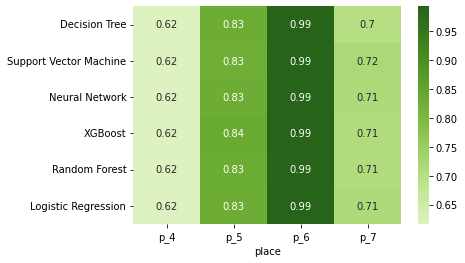

In [19]:
import seaborn as sns

sns.heatmap(res.transpose(), annot=True, cmap="PiYG", center=0.5)